<a href="https://colab.research.google.com/github/BoyoungH/2D-to-3D-Nerf/blob/main/tiny_nerf_sofa.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

See my notebook [here](https://colab.research.google.com/drive/1MY6pk3vY7rrYal8oS6_s7zTkGN9lkHQr?usp=sharing) demonstrating how to use my code to train a NeRF model on the `tiny_nerf_data.npz` file used by the original NeRF authors in their notebook [here](https://colab.research.google.com/github/bmild/nerf/blob/master/tiny_nerf.ipynb).

In [ ]:
!wget "https://github.com/airalcorn2/pytorch-nerf/blob/master/66bdbc812bd0a196e194052f3f12cb2e.npz?raw=True" -O 66bdbc812bd0a196e194052f3f12cb2e.npz

--2023-05-02 15:35:52--  https://github.com/airalcorn2/pytorch-nerf/blob/master/66bdbc812bd0a196e194052f3f12cb2e.npz?raw=True
Resolving github.com (github.com)... 20.205.243.166
Connecting to github.com (github.com)|20.205.243.166|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/airalcorn2/pytorch-nerf/raw/master/66bdbc812bd0a196e194052f3f12cb2e.npz [following]
--2023-05-02 15:35:52--  https://github.com/airalcorn2/pytorch-nerf/raw/master/66bdbc812bd0a196e194052f3f12cb2e.npz
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/airalcorn2/pytorch-nerf/master/66bdbc812bd0a196e194052f3f12cb2e.npz [following]
--2023-05-02 15:35:53--  https://raw.githubusercontent.com/airalcorn2/pytorch-nerf/master/66bdbc812bd0a196e194052f3f12cb2e.npz
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
C

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torch

from torch import nn, optim


def get_coarse_query_points(ds, N_c, t_i_c_bin_edges, t_i_c_gap, os):
    u_is_c = torch.rand(*list(ds.shape[:2]) + [N_c]).to(ds)
    t_is_c = t_i_c_bin_edges + u_is_c * t_i_c_gap
    r_ts_c = os[..., None, :] + t_is_c[..., :, None] * ds[..., None, :]
    return (r_ts_c, t_is_c)


def render_radiance_volume(r_ts, ds, chunk_size, F, t_is):
    r_ts_flat = r_ts.reshape((-1, 3))
    ds_rep = ds.unsqueeze(2).repeat(1, 1, r_ts.shape[-2], 1)
    ds_flat = ds_rep.reshape((-1, 3))

    # Split flattened input into batches
    num_samples = r_ts_flat.shape[0]
    num_batches = (num_samples + chunk_size - 1) // chunk_size

    c_is_list = []
    sigma_is_list = []
    for i in range(num_batches):
        start_idx = i * chunk_size
        end_idx = min((i + 1) * chunk_size, num_samples)
        r_ts_batch = r_ts_flat[start_idx:end_idx]
        ds_batch = ds_flat[start_idx:end_idx]
        preds = F(r_ts_batch, ds_batch)
        c_is_list.append(preds["c_is"])
        sigma_is_list.append(preds["sigma_is"])

    c_is = torch.cat(c_is_list, dim=0).reshape(r_ts.shape)
    sigma_is = torch.cat(sigma_is_list, dim=0).reshape(r_ts.shape[:-1])

    delta_is = t_is[..., 1:] - t_is[..., :-1]
    one_e_10 = torch.Tensor([1e10]).expand(delta_is[..., :1].shape)
    delta_is = torch.cat([delta_is, one_e_10.to(delta_is)], dim=-1)
    delta_is = delta_is * ds.norm(dim=-1).unsqueeze(-1)

    alpha_is = 1.0 - torch.exp(-sigma_is * delta_is)

    T_is = torch.cumprod(1.0 - alpha_is + 1e-10, -1)
    T_is = torch.roll(T_is, 1, -1)
    T_is[..., 0] = 1.0

    w_is = T_is * alpha_is

    C_rs = (w_is[..., None] * c_is).sum(dim=-2)

    return C_rs


def run_one_iter_of_tiny_nerf(ds, N_c, t_i_c_bin_edges, t_i_c_gap, os, chunk_size, F_c):
    (r_ts_c, t_is_c) = get_coarse_query_points(ds, N_c, t_i_c_bin_edges, t_i_c_gap, os)
    C_rs_c = render_radiance_volume(r_ts_c, ds, chunk_size, F_c, t_is_c)
    return C_rs_c


class VeryTinyNeRFMLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.L_pos = 6
        self.L_dir = 4
        pos_enc_feats = 3 + 3 * 2 * self.L_pos
        dir_enc_feats = 3 + 3 * 2 * self.L_dir

        net_width = 256
        self.early_mlp = nn.Sequential(
            nn.Linear(pos_enc_feats, net_width),
            nn.ReLU(),
            nn.Linear(net_width, net_width + 1),
            nn.ReLU(),
        )
        self.late_mlp = nn.Sequential(
            nn.Linear(net_width + dir_enc_feats, net_width),
            nn.ReLU(),
            nn.Linear(net_width, 3),
            nn.Sigmoid(),
        )

    def forward(self, xs, ds):
        xs_encoded = [xs]
        for l_pos in range(self.L_pos):
            xs_encoded.append(torch.sin(2 ** l_pos * torch.pi * xs))
            xs_encoded.append(torch.cos(2 ** l_pos * torch.pi * xs))

        xs_encoded = torch.cat(xs_encoded, dim=-1)

        ds = ds / ds.norm(p=2, dim=-1).unsqueeze(-1)
        ds_encoded = [ds]
        for l_dir in range(self.L_dir):
            ds_encoded.append(torch.sin(2 ** l_dir * torch.pi * ds))
            ds_encoded.append(torch.cos(2 ** l_dir * torch.pi * ds))

        ds_encoded = torch.cat(ds_encoded, dim=-1)

        outputs = self.early_mlp(xs_encoded)
        sigma_is = outputs[:, 0]
        c_is = self.late_mlp(torch.cat([outputs[:, 1:], ds_encoded], dim=-1))
        return {"c_is": c_is, "sigma_is": sigma_is}

(251, 128, 128, 3)


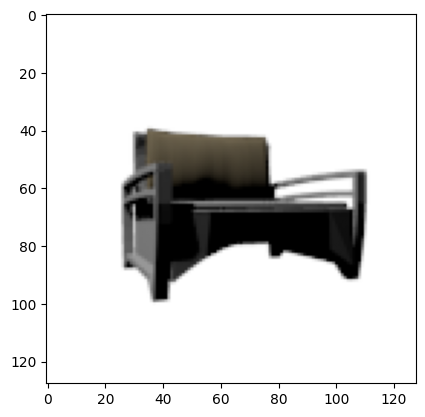

VeryTinyNeRFMLP(
  (early_mlp): Sequential(
    (0): Linear(in_features=39, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=257, bias=True)
    (3): ReLU()
  )
  (late_mlp): Sequential(
    (0): Linear(in_features=283, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=3, bias=True)
    (3): Sigmoid()
  )
)

In [ ]:
seed = 9458
torch.manual_seed(seed)
np.random.seed(seed)

device = "cuda:0"
F_c = VeryTinyNeRFMLP().to(device)
chunk_size = 16384

lr = 5e-3
optimizer = optim.Adam(F_c.parameters(), lr=lr)
criterion = nn.MSELoss()

data_f = "tiny_nerf_j.npz"
data = np.load(data_f)

images = data["normalized_array"] #/ 255
img_size = images.shape[1]
xs = torch.arange(img_size) - (img_size / 2 - 0.5)
ys = torch.arange(img_size) - (img_size / 2 - 0.5)
(xs, ys) = torch.meshgrid(xs, -ys, indexing="xy")
focal = float(data["focal"])
pixel_coords = torch.stack([xs, ys, torch.full_like(xs, -focal)], dim=-1)
camera_coords = pixel_coords / focal
init_ds = camera_coords.to(device)
init_o = torch.Tensor(np.array([0, 0, 2.25])).to(device)
print(images.shape)
test_idx = 0
plt.imshow(images[test_idx])
plt.show()
test_img = torch.Tensor(images[test_idx]).to(device)
poses = data["poses"]
test_R = torch.Tensor(poses[test_idx, :3, :3]).to(device)
test_ds = torch.einsum("ij,hwj->hwi", test_R, init_ds)
test_os = (test_R @ init_o).expand(test_ds.shape)


t_n = 1.0
t_f = 4.0
N_c = 32
t_i_c_gap = (t_f - t_n) / N_c
t_i_c_bin_edges = (t_n + torch.arange(N_c) * t_i_c_gap).to(device)

train_idxs = np.arange(len(images)) != test_idx
images = torch.Tensor(images[train_idxs])
poses = torch.Tensor(poses[train_idxs])
psnrs = []
iternums = []
num_iters = 2000
display_every = 100
F_c.train()

In [ ]:
!nvidia-smi

Tue May  2 15:35:59 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   43C    P0    27W /  70W |    137MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

Loss: 0.2531050443649292


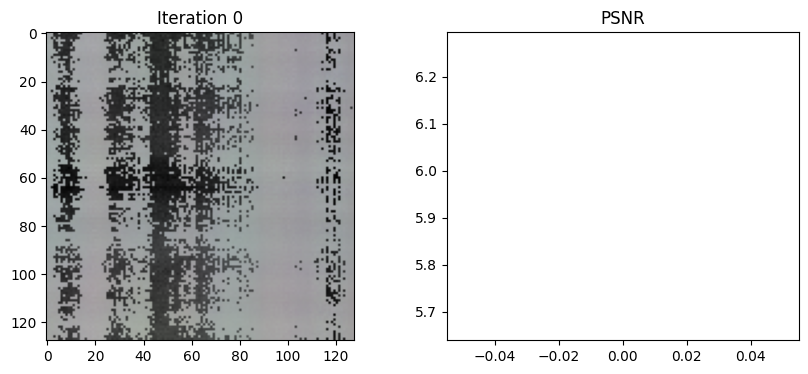

Loss: 0.0483110249042511


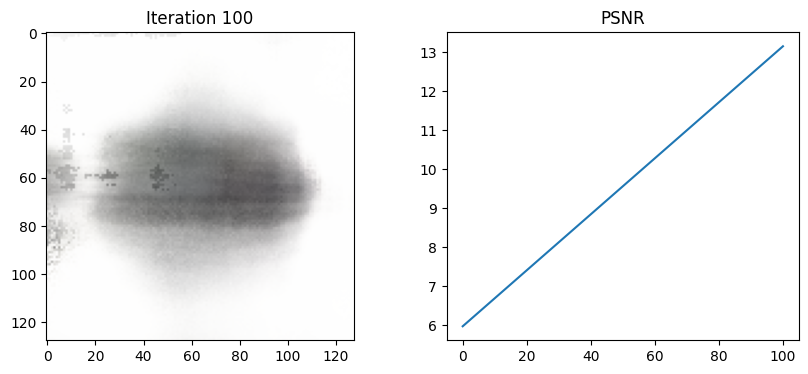

Loss: 0.06087213382124901


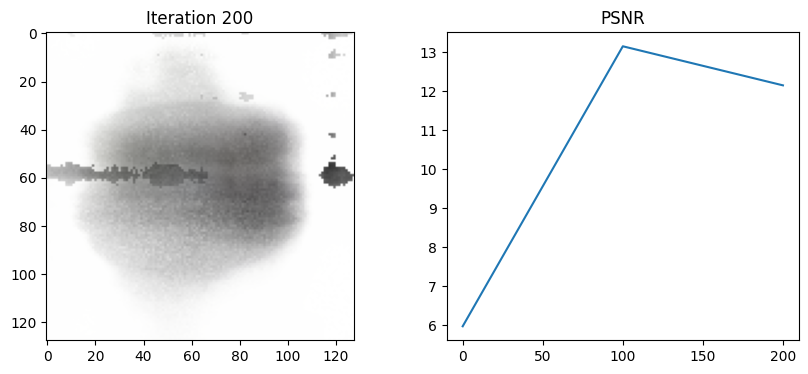

Loss: 0.0574306920170784


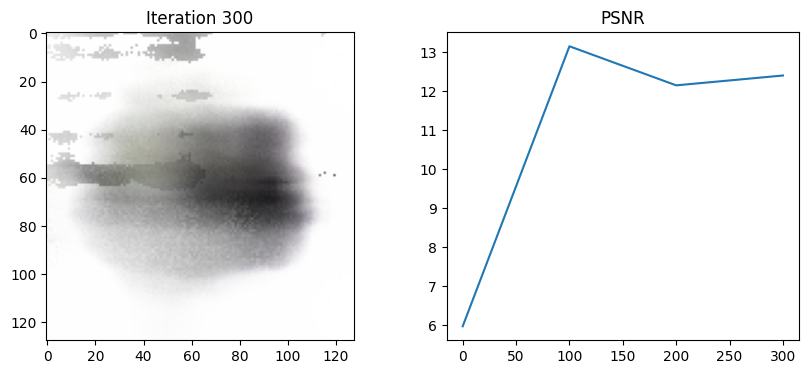

Loss: 0.03820883855223656


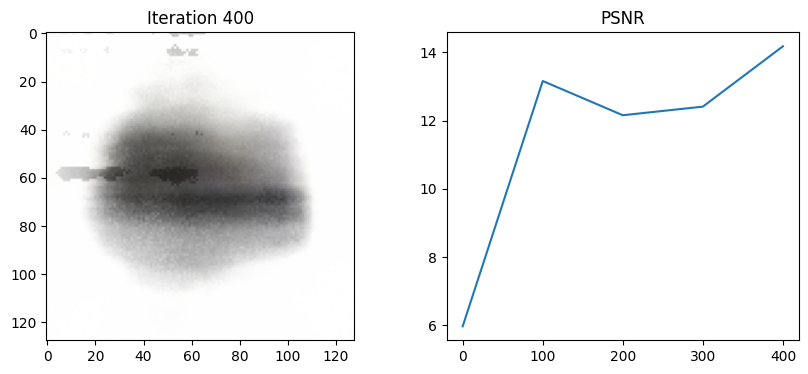

Loss: 0.03664427250623703


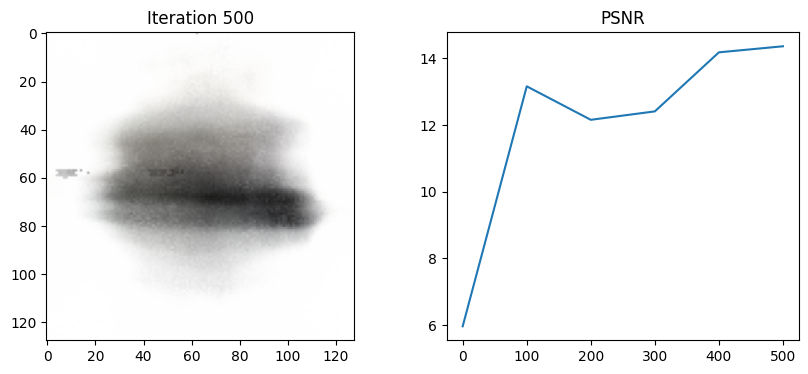

Loss: 0.03981862589716911


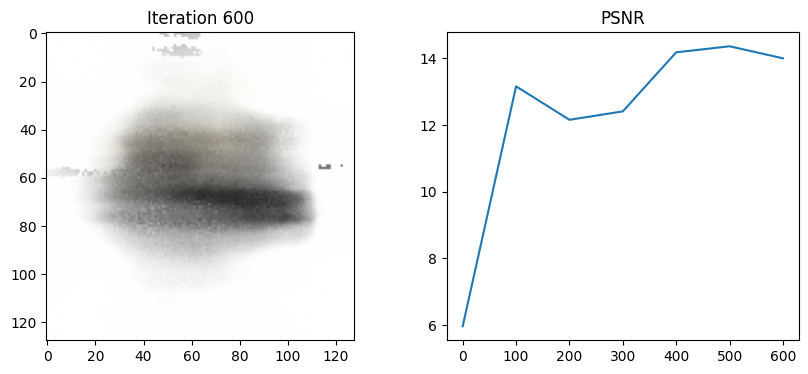

Loss: 0.03447403758764267


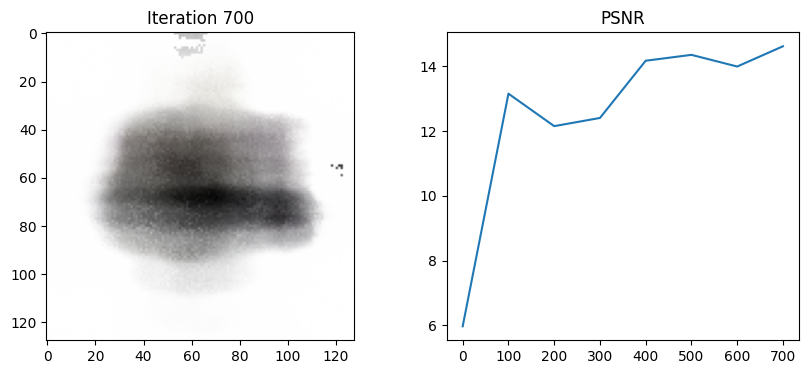

Loss: 0.030115589499473572


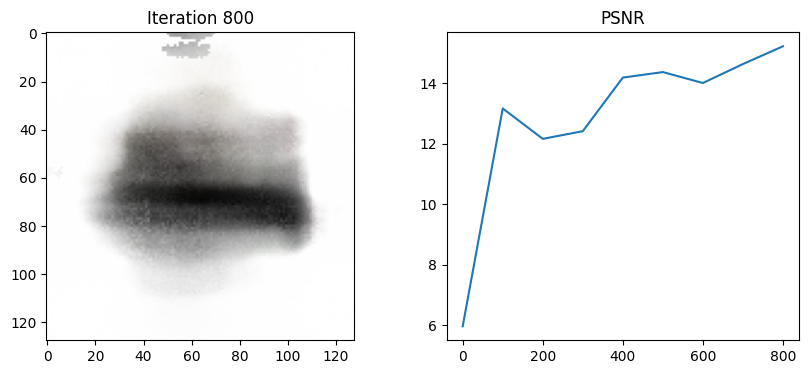

Loss: 0.034262292087078094


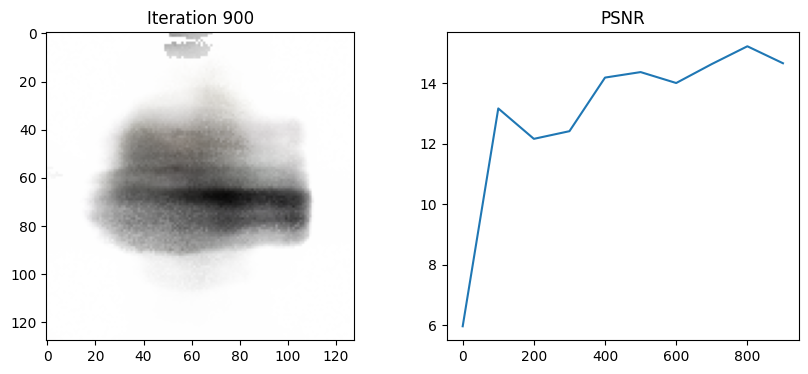

Loss: 0.027002787217497826


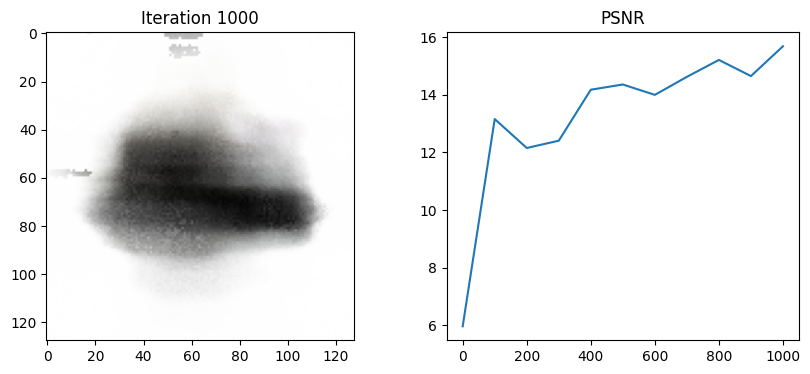

Loss: 0.03045818954706192


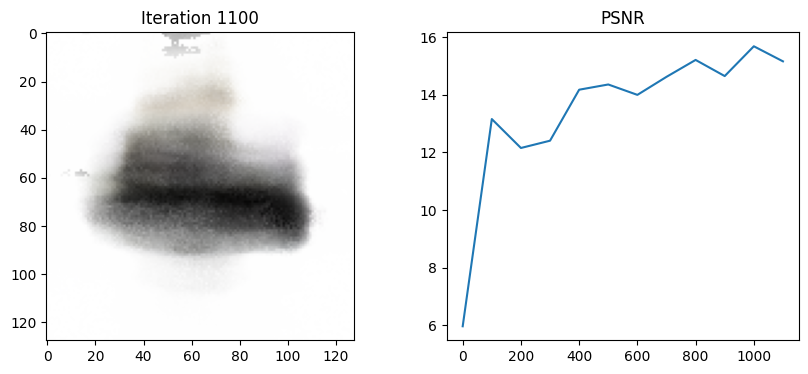

Loss: 0.030484896153211594


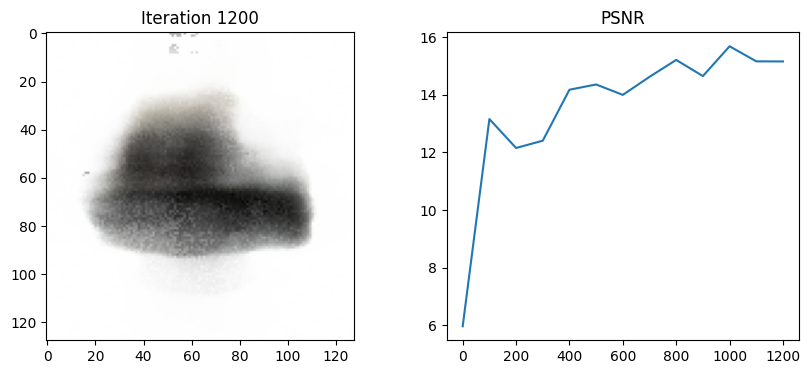

Loss: 0.028199300169944763


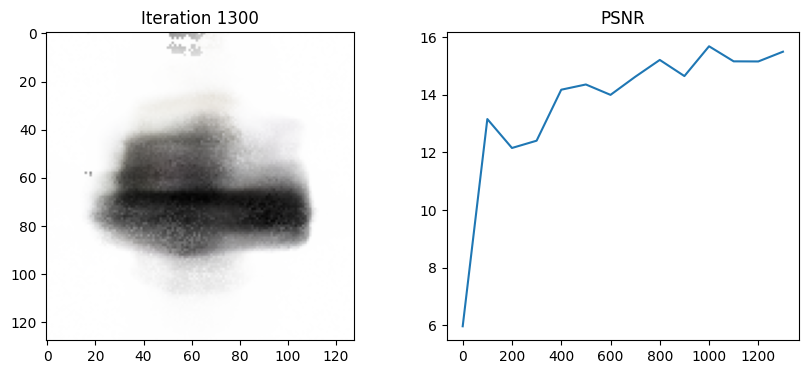

Loss: 0.026510026305913925


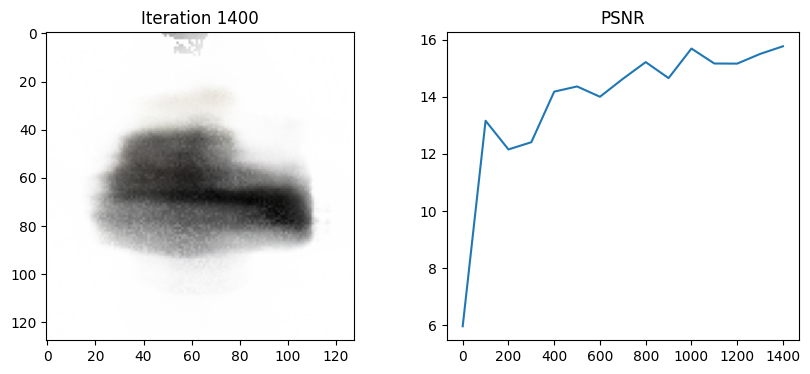

Loss: 0.02447495423257351


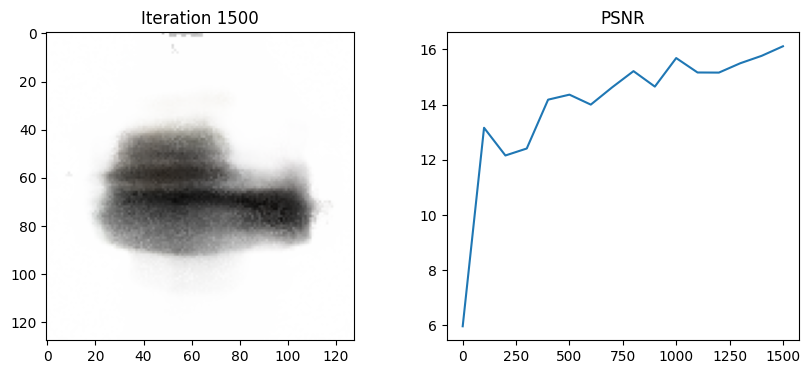

Loss: 0.02518751285970211


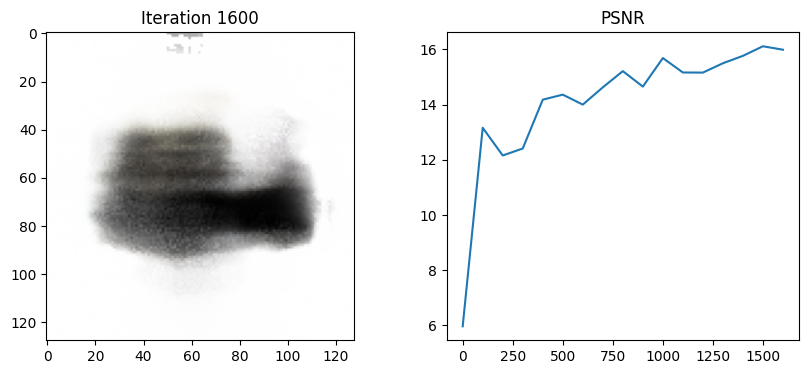

Loss: 0.02431887947022915


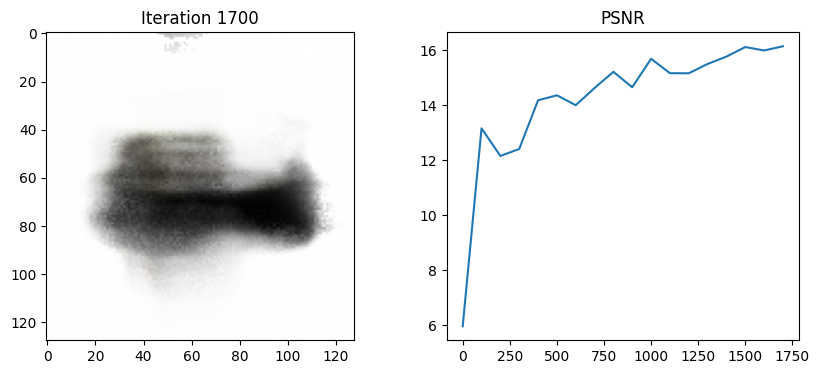

Loss: 0.026547659188508987


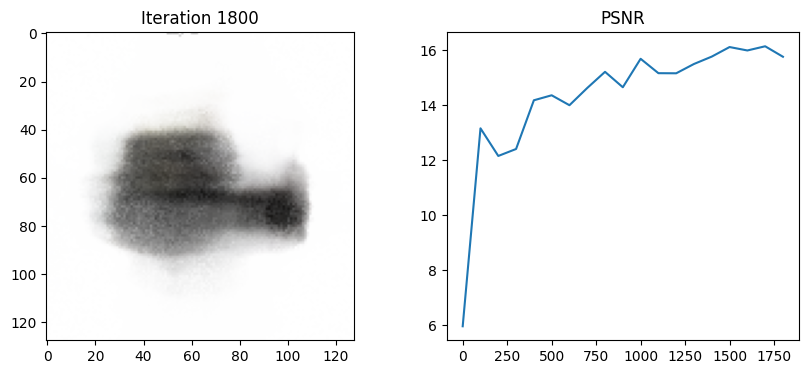

Loss: 0.02683226391673088


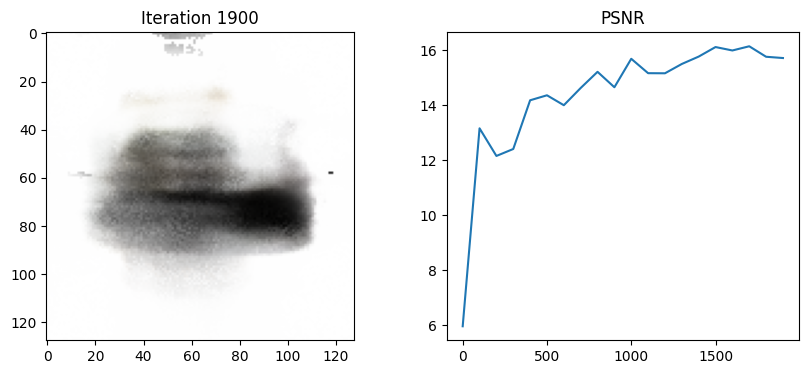

Done!


In [ ]:
for i in range(num_iters):
    target_img_idx = np.random.randint(images.shape[0])
    target_pose = poses[target_img_idx].to(device)
    R = target_pose[:3, :3]

    ds = torch.einsum("ij,hwj->hwi", R, init_ds)
    os = (R @ init_o).expand(ds.shape)

    C_rs_c = run_one_iter_of_tiny_nerf(
        ds, N_c, t_i_c_bin_edges, t_i_c_gap, os, chunk_size, F_c
    )
    loss = criterion(C_rs_c, images[target_img_idx].to(device))
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if i % display_every == 0:
        F_c.eval()
        with torch.no_grad():
            C_rs_c = run_one_iter_of_tiny_nerf(
                test_ds, N_c, t_i_c_bin_edges, t_i_c_gap, test_os, chunk_size, F_c
            )

        loss = criterion(C_rs_c, test_img)
        print(f"Loss: {loss.item()}")
        psnr = -10.0 * torch.log10(loss)

        psnrs.append(psnr.item())
        iternums.append(i)

        plt.figure(figsize=(10, 4))
        plt.subplot(121)
        plt.imshow(C_rs_c.detach().cpu().numpy())
        plt.title(f"Iteration {i}")
        plt.subplot(122)
        plt.plot(iternums, psnrs)
        plt.title("PSNR")
        plt.show()

        F_c.train()

print("Done!")

In [ ]:
%matplotlib inline
from ipywidgets import interactive, widgets
import numpy as np
import torch
import torchvision.transforms.functional as F
from torchvision.transforms import InterpolationMode
from torch.autograd import grad
import torch.nn.functional as nnF

def trans_t(t):
  return torch.tensor([
  [1,0,0,0],
  [0,1,0,0],
  [0,0,1,t],
  [0,0,0,1],
  ], dtype=torch.float32)

def rot_phi(phi):
    phi = torch.tensor(phi)
    return torch.tensor([
        [1, 0, 0, 0],
        [0, torch.cos(phi), -torch.sin(phi), 0],
        [0, torch.sin(phi), torch.cos(phi), 0],
        [0, 0, 0, 1],
    ], dtype=torch.float32)

def rot_theta(th):
    th = torch.tensor(th)
    return torch.tensor([
        [torch.cos(th), 0, -torch.sin(th), 0],
        [0, 1, 0, 0],
        [torch.sin(th), 0, torch.cos(th), 0],
        [0, 0, 0, 1],
    ], dtype=torch.float32)

def pose_spherical(theta, phi, radius):
  c2w = trans_t(radius)
  c2w = rot_phi(phi/180.*np.pi) @ c2w
  c2w = rot_theta(theta/180.*np.pi) @ c2w
  c2w = torch.tensor([[-1,0,0,0],[0,0,1,0],[0,1,0,0],[0,0,0,1]], dtype=torch.float32) @ c2w
  return c2w

def f(**kwargs):
  c2w = pose_spherical(**kwargs)
  c2w = c2w.to(device)
  test_R = torch.Tensor(poses[test_idx, :3, :3]).to(device)
  test_R = c2w[:3, :3].to(device)
  test_ds = torch.einsum("ij,hwj->hwi", test_R, init_ds)
  test_os = (test_R @ init_o).expand(test_ds.shape)
  C_rs_c = run_one_iter_of_tiny_nerf(test_ds, N_c, t_i_c_bin_edges, t_i_c_gap, test_os, chunk_size, F_c)
  img = torch.clamp((C_rs_c.detach()), 0, 1)
  img = img.permute(2, 0, 1)

  img_np = img.cpu().numpy()
  plt.figure(2, figsize=(20,6))
  plt.imshow(img_np.transpose(1, 2, 0))
  plt.show()

sldr = lambda v, mi, ma: widgets.FloatSlider(
  value=v,
  min=mi,
  max=ma,
  step=.01,
)

names = [
  ['theta', [100., 0., 360]],
  ['phi', [-30., -90, 0]],
  ['radius', [4., 3., 5.]],
]

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
interactive_plot = interactive(f, **{s[0] : sldr(*s[1]) for s in names})
output = interactive_plot.children[-1]
output.layout.height = '350px'
interactive_plot

interactive(children=(FloatSlider(value=100.0, description='theta', max=360.0, step=0.01), FloatSlider(value=-…

In [ ]:
frames = []
from tqdm import tqdm_notebook as tqdm
for th in tqdm(np.linspace(0., 360., 120, endpoint=False)):
    c2w = pose_spherical(th,-77, 4.)
    #test_R = torch.Tensor(poses[test_idx, :3, :3]).to(device)
    test_R = c2w[:3, :3].to(device)
    test_ds = torch.einsum("ij,hwj->hwi", test_R, init_ds)
    test_os = (test_R @ init_o).expand(test_ds.shape)
    C_rs_c = run_one_iter_of_tiny_nerf(test_ds, N_c, t_i_c_bin_edges, t_i_c_gap, test_os, chunk_size, F_c)
    #frames.append((C_rs_c.detach().cpu().numpy()).astype(np.uint8))
    frames.append((255*np.clip(C_rs_c.detach().cpu().numpy(),0,1)).astype(np.uint8))

import imageio
f = 'video.mp4'
imageio.mimwrite(f, frames, fps=30, quality=7)

<ipython-input-7-20696a35f38d>:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for th in tqdm(np.linspace(0., 360., 120, endpoint=False)):


  0%|          | 0/120 [00:00<?, ?it/s]

In [ ]:
from IPython.display import HTML
from base64 import b64encode
mp4 = open('video.mp4','rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML("""
<video width=400 controls autoplay loop>
      <source src="%s" type="video/mp4">
</video>
""" % data_url)